# Оценка результатов A/B-теста: выпускной проект

## Описание проекта:

В данном проекте проводится анализ результатов A/B-тестирования изменений, связанных с внедрением улучшенной рекомендательной системы, а также изучается влияние этих изменений на платежную воронку. Кроме того, оценивается корректность проведения теста на предмет пересечения тестовой аудитории с конкурирующим тестом, совпадения теста и маркетинговых событий, а также исследуется наличие других проблем временных границ теста.

**Техническое задание:**

- *Группы:* А — контрольная, B — новая платёжная воронка;
- *Дата запуска:* 2020-12-07;
- *Дата остановки набора новых пользователей:* 2020-12-21;
- *Дата остановки:* 2021-01-04;
- *Аудитория:* 15% новых пользователей из региона EU;
- *Ожидаемое количество участников теста:* 6000;
- *Ожидаемый эффект:* за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%.

## Главные выводы:

По результатам исследования, можем заключить, что тест был проведен с большим количеством нарушений, и его результаты не должны считаться валидными:

* В обеих группах присутствует определенное число выбросов, искажающих данные о распределении, кроме того, сами распределения далеки от нормальных.
* Группы были набраны неравномерно - контрольная группа A почти в три раза больше, чем группа B, и объема выборок недостаточно, чтобы зарегистрировать значимые изменения согласно поставленному тех.заданию.
* Время проведения тестирования было выбрано неудачно - оно совпадает с рождественским / новогодним сезоном праздников, что влияет на результаты теста.
* Эксперимент планировалось завершить 4 января 2021, однако данные по событиям не поступали после 30 декабря - не исключены технические ошибки логирования.
* Механизм разбиения пользователей на группы работает с ошибками - группы нельзя назвать разбитыми случайно: они не только кардинально различаются по размеру, но и различаются по составу устройств (больше стационарных устройств в контрольной группе и больше мобильных - в экспериментальной), а это вносит серьезные искажения в результаты.

При этом, отметим, что мы наблюдали снижение конверсии на всех шагах воронки в группе B, хотя единственным статистически значимым различием можно условно назвать лишь этап корзины. Этим результатам не следует доверять, но не исключено, что изменения в рекомендательной системе действительно могли негативно повлиять на пользовательский опыт - это предположение следует проверить с помощью организации нового теста, который учтет все замечания и исключит ошибки.

## Содержание проекта:<a name="introduction"></a>

### 1. [Общая информация о данных](#paragraph1)

### 2. [Предобработка данных](#paragraph2)

* 2.1 [Проверка типов данных](#subparagraph2_1)
* 2.2 [Проверка на пропуски](#subparagraph2_2)
* 2.3 [Проверка на дубликаты](#subparagraph2_3)
* 2.4 [Фильтрация данных в соответствии с поставленным тех.заданием](#subparagraph2_4)

### 3. [Исследовательский анализ данных](#paragraph3)

* 3.1 [Изменения конверсии в воронке на разных этапах](#subparagraph3_1)
* 3.2 [Количество событий на одного пользователя](#subparagraph3_2)
* 3.3 [Проверка на предмет принадлежности пользователей к обеим группам одновременно или к конкурирующим тестам](#subparagraph3_3)
* 3.4 [Распределение числа событий по дням](#subparagraph3_4)
* 3.5 [Особенности данных](#subparagraph3_5)

### 4. [Проверка статистических гипотез](#paragraph4)

### 5. [Общий вывод](#paragraph5)

## 1. Общая информация о данных<a name="paragraph1"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from scipy import stats as st
from statsmodels.stats.multitest import multipletests
import math as mth
plt.rcParams['figure.figsize'] = (16, 8)
pio.renderers.default = 'notebook_connected'

* `ab_project_marketing_events` — календарь маркетинговых событий на 2020 год

In [2]:
ab_project_marketing_events = pd.read_csv('ab_project_marketing_events.csv')

In [3]:
ab_project_marketing_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


In [4]:
ab_project_marketing_events.head()

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


**Вывод:** таблица `ab_project_marketing_events` (календарь маркетинговых событий) состоит из 14 строк и 4 столбцов: `name` — название маркетингового события; `regions` — регионы, в которых будет проводиться рекламная кампания; `start_dt` — дата начала кампании; `finish_dt` — дата завершения кампании.

* `final_ab_new_users` таблица с данными пользователей, зарегистрировавшихся с 7 по 21 декабря 2020 г.

In [5]:
final_ab_new_users = pd.read_csv('final_ab_new_users.csv')

In [6]:
final_ab_new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


In [7]:
final_ab_new_users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


**Вывод:** таблица `final_ab_new_users` (новые пользователи с 7 по 21 декабря 2020) содержит 61733 строк и 4 столбца: `user_id` — идентификатор пользователя; `first_date` — дата регистрации; `region` — регион пользователя; `device` — устройство, с которого происходила регистрация.

* `final_ab_events` - действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года

In [8]:
final_ab_events = pd.read_csv('final_ab_events.csv')

In [9]:
final_ab_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


In [10]:
final_ab_events.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


**Вывод:** таблица `final_ab_events` (действия новых пользователей) содержит 440317 строк и 4 столбца: `user_id` — идентификатор пользователя; `event_dt` — дата и время покупки; `event_name` — тип события; `details` — дополнительные данные о событии.

* `final_ab_participants` — таблица участников A/B - тестов

In [11]:
final_ab_participants = pd.read_csv('final_ab_participants.csv')

In [12]:
final_ab_participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


In [13]:
final_ab_participants.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


**Вывод:** таблица `final_ab_participants` (таблица участников тестов) содержит 18268 строк и 3 столбца: `user_id` — идентификатор пользователя; `ab_test` — название теста; `group` — группа пользователя.

[Вернуться к оглавлению](#introduction)

## 2. Предобработка данных<a name="paragraph2"></a>

### 2.1 Проверка типов данных<a name="subparagraph2_1"></a>

* Таблица `ab_project_marketing_events`

In [14]:
ab_project_marketing_events.dtypes

name         object
regions      object
start_dt     object
finish_dt    object
dtype: object

In [15]:
ab_project_marketing_events['start_dt'] = pd.to_datetime(ab_project_marketing_events['start_dt'])
ab_project_marketing_events['finish_dt'] = pd.to_datetime(ab_project_marketing_events['finish_dt'])

In [16]:
ab_project_marketing_events.dtypes

name                 object
regions              object
start_dt     datetime64[ns]
finish_dt    datetime64[ns]
dtype: object

**Вывод:** типы столбцов `start_dt` и `finish_dt` были изменены на datetime. Остальные типы определены корректно.

* Таблица `final_ab_new_users`

In [17]:
final_ab_new_users.dtypes

user_id       object
first_date    object
region        object
device        object
dtype: object

In [18]:
final_ab_new_users['first_date'] = pd.to_datetime(final_ab_new_users['first_date'])

In [19]:
final_ab_new_users.dtypes

user_id               object
first_date    datetime64[ns]
region                object
device                object
dtype: object

**Вывод:** тип столбца `first_date` был изменен на datetime. Остальные типы определены корректно.

* Таблица `final_ab_events`

In [20]:
final_ab_events.dtypes

user_id        object
event_dt       object
event_name     object
details       float64
dtype: object

In [21]:
final_ab_events['event_dt'] = pd.to_datetime(final_ab_events['event_dt'])

In [22]:
final_ab_events.dtypes

user_id               object
event_dt      datetime64[ns]
event_name            object
details              float64
dtype: object

**Вывод:** тип столбца `event_dt` был изменен на datetime. Остальные типы определены корректно.

* Таблица `final_ab_participants`

In [23]:
final_ab_participants.dtypes

user_id    object
group      object
ab_test    object
dtype: object

**Вывод:** все типы данных определены корректно.

### 2.2 Проверка на пропуски<a name="subparagraph2_2"></a>

* Таблица `ab_project_marketing_events`

In [24]:
ab_project_marketing_events.isna().sum() 

name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

**Вывод:** пропуски отсутствуют

* Таблица `final_ab_new_users`

In [25]:
final_ab_new_users.isna().sum()

user_id       0
first_date    0
region        0
device        0
dtype: int64

**Вывод:** пропуски отсутствуют

* Таблица `final_ab_events`

In [26]:
final_ab_events.isna().sum()

user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64

In [27]:
final_ab_events['event_name'].unique()

array(['purchase', 'product_cart', 'product_page', 'login'], dtype=object)

In [28]:
final_ab_events[final_ab_events['details'].isnull()]['event_name'].unique()

array(['product_cart', 'product_page', 'login'], dtype=object)

**Вывод:** пропуски обнаружены только для столбца `details`. Это связано с организацией базы данных - численные значения проставляются только для событий покупки, а во всех остальных типах событий проставляются пропущенные значения, которые нельзя заполнять или устранять.

* Таблица `final_ab_participants`

In [29]:
final_ab_participants.isna().sum()

user_id    0
group      0
ab_test    0
dtype: int64

**Вывод:** пропуски отсутствуют

### 2.3 Проверка на дубликаты<a name="subparagraph2_3"></a>

In [30]:
print('Количество полных дубликатов:', ab_project_marketing_events.duplicated().sum())

Количество полных дубликатов: 0


In [31]:
print('Количество полных дубликатов:', final_ab_new_users.duplicated().sum())

Количество полных дубликатов: 0


In [32]:
print('Количество полных дубликатов:', final_ab_events.duplicated().sum())

Количество полных дубликатов: 0


In [33]:
print('Количество полных дубликатов:', final_ab_participants.duplicated().sum())

Количество полных дубликатов: 0


**Вывод:** дубликаты отсутствуют по всех имеющихся таблицах.

### 2.4 Фильтрация данных в соответствии с поставленным тех.заданием<a name="subparagraph2_4"></a>

Сначала объединим данные из разных источников

In [34]:
data = final_ab_new_users.merge(final_ab_events, on='user_id', how='outer')
data = data.merge(final_ab_participants, on='user_id', how='outer')

Отфильтруем только тех пользователей, кто участвовал в A/B-тестировании рекомендательной системы (recommender_system_test) и сохраним нужную часть данных в датафрейме `data_ab`. Так мы исключим пересечения с конкурирующими тестами.

In [35]:
data_ab = data.query('ab_test == "recommender_system_test"')

Далее ограничим набор новых пользователей датой 2020-12-21.

In [36]:
data_ab = data_ab.query('first_date <= "2020-12-21"')

Ограничим события интересующим нас периодом с 2020-12-07 по 2021-01-04.

In [37]:
data_ab = data_ab.query('event_dt >= "2020-12-07" & event_dt <= "2021-01-04"')

Зная, что тестирование планировалось с 2020-12-07 по 2021-01-04, выясним, совпадает ли интересующий нас период с маркетинговыми активностями, которые могли бы исказить результаты тестирования.

In [38]:
ab_project_marketing_events \
.query('start_dt >= "2020-12-07" & start_dt <= "2021-01-04" | \
        finish_dt >= "2020-12-07" & finish_dt <= "2021-01-04"')

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


Поскольку тестирование проводится на регионе EU, можно утверждать, что есть одно пересечение - новогодняя/рождественская промоакция, которая может повлиять на результаты. Тестирование не следовало назначать на период, который может совпадать с маркетинговыми активностями и праздниками.

Проверим, все ли отобранные для теста пользователи действительно пришли из региона EU.

In [39]:
data_ab['region'].value_counts()

EU           23420
N.America      838
APAC           232
CIS            208
Name: region, dtype: int64

Видим, что механизм отбора пользователей отработал с ошибками - помимо пользователей из Евросоюза, в выборку попали также некоторые пользователи из СНГ, Азиатско-Тихоокеанского региона и Северной Америки. Так как для теста нас интересуют лишь европейские пользователи, остальные группы следует исключить из датасета.

In [40]:
data_ab = data_ab.query('region == "EU"')

In [41]:
print('Есть данные по событиям с', data_ab['event_dt'].describe()[4], 'по', data_ab['event_dt'].describe()[5])

Есть данные по событиям с 2020-12-07 00:05:57 по 2020-12-30 12:42:57


Заданным в тех.задании условиям соответствует только временной промежуток с 7 по 30 декабря 2020.

In [42]:
print('Количество уникальных пользователей, участвующих в тестировании:', data_ab['user_id'].unique().shape[0])

Количество уникальных пользователей, участвующих в тестировании: 3481


Количество пользователей, которые подходят под поставленную задачу лишь 3481, а не около 6000, как предполагалось.

[Вернуться к оглавлению](#introduction)

## 3. Исследовательский анализ данных<a name="paragraph3"></a>

### 3.1 Изменения конверсии в воронке на разных этапах<a name="subparagraph3_1"></a>

Посчитаем общее количество различных событий в выборке за исследуемый период - `event_counts`

In [43]:
event_counts = data_ab['event_name'].value_counts().reset_index()

In [44]:
event_counts = event_counts.rename(columns={'index':'event_name', 'event_name':'n_events'})

In [45]:
fig = px.bar(event_counts.replace({'event_name':{'login':'Вход', 'product_page':'Страница с товаром',
                                            'product_cart':'Корзина','purchase':'Покупка'}}), 
                                  x='event_name', y='n_events', template='none', 
                                  title='Общее число вызова различных событий', text='n_events')
fig.update_xaxes(title='Название события')
fig.update_yaxes(title='Общее число вызова события')
fig.update_traces(textposition='outside')
fig.show()

**Вывод:** всего в данных 4 различных типа события, `login` - вход в систему, `product_page` - просмотр карточки товара, `product_cart` - просмотр корзины, `purchase` - совершение покупки. Важно отметить, что в данных больше событий покупок, чем событий входа в корзину. Этот факт противоречит логике воронки, которая предусматривает порядок "login - product_page - product_cart - purchase". При этом не исключено, что на странице товара может быть кнопка быстрой покупки, которая сразу ведет на экран оплаты, минуя посещение корзины. Данное предположение нуждается в проверке. Кроме того, можно предположить, что это связано с ошибками в регистрации некоторых событий пользователей.

Далее рассмотрим количество уникальных пользователей совершивших различные события.

In [46]:
event_counts_unique = data_ab.groupby('event_name')['user_id'].nunique().sort_values(ascending=False).reset_index()

In [47]:
fig = px.bar(event_counts_unique.replace({'event_name':{'login':'Вход', 'product_page':'Страница с товаром',
                                            'product_cart':'Корзина','purchase':'Покупка'}}), 
                                  x='event_name', y='user_id', template='none', 
                                  title='Количество уникальных пользователей, совершивших различные события', text='user_id')
fig.update_xaxes(title='Название события')
fig.update_yaxes(title='Число уникальных пользователей')
fig.update_traces(textposition='outside')
fig.show()

**Вывод:** вновь мы видим, что число пользователей, совершивших покупку выше, чем число пользователей, посетивших корзину.

Далее визуализируем воронку событий

In [48]:
event_counts_unique['index'] = [1,2,4,3]

In [49]:
funnel = event_counts_unique.sort_values(by='index').replace({'event_name':{'login':'Вход', 'product_page':'Страница с товаром',
                                            'product_cart':'Корзина','purchase':'Покупка'}})

In [50]:
fig = go.Figure()
fig.add_trace(go.Funnel(
    name = 'Funnel',
    y = funnel['event_name'],
    x = funnel['user_id'],
    textinfo = "value+percent initial+percent previous"))
fig.update_layout(title='Воронка событий', title_x = 0.54)
fig.show()

**Вывод:** первый этап воронки - *логин* - выполнили все пользователи из выборки. На втором этапе - *посещения страницы с товаром* - остались 63% пользователей. Третий этап - *корзину* - посетили 29% от первоначального числа пользователей. До финального этапа *покупки* дошли 31% пользователей. Как мы предположили ранее, 2% пользователей могли вполне пропустить этап корзины, если воспользовались кнопкой быстрой оплаты. Таким образом следует учитывать эту особенность воронки - гипотетически, если корзина не является обязательным этапом, то ее не вполне правомерно рассматривать как отдельный этап, и следует рассматривать сразу конверсию из страницы с товаром в покупку.

* Разделим чистые данные на датасеты для группы А и В - `data_a` и `data_b` соответственно.

In [51]:
data_a = data_ab.query('group == "A"')
data_b = data_ab.query('group == "B"')

In [52]:
print('Количество уникальных пользователей в группе A:', data_a['user_id'].unique().shape[0])
print('Количество уникальных пользователей в группе B:', data_b['user_id'].unique().shape[0])

Количество уникальных пользователей в группе A: 2604
Количество уникальных пользователей в группе B: 877


**Вывод:** группы для тестирования распределены не равномерно - в *группе А*: 2604 пользователя (74.8% от общей выборки), а в *группе В*: 877 пользователей (25.2%) - механизм разбиения пользователей на группы для тестирования работает не корректно, и это может повлиять на результаты тестирования.

### 3.2 Количество событий на одного пользователя<a name="subparagraph3_2"></a>

Рассчитаем количество событий на пользователя в целом по общей выборке - `events_per_user`

In [53]:
events_per_user = data_ab.groupby('user_id')['event_name'].count()
print('Описательные статистики для количества событий на пользователя:')
events_per_user.describe()

Описательные статистики для количества событий на пользователя:


count    3481.000000
mean        6.727952
std         3.815552
min         1.000000
25%         4.000000
50%         6.000000
75%         9.000000
max        28.000000
Name: event_name, dtype: float64

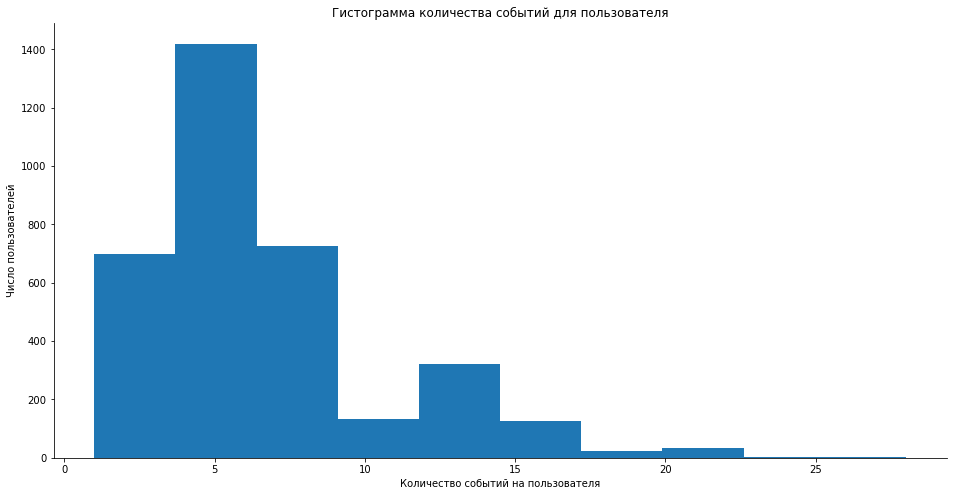

In [54]:
events_per_user.hist()
plt.title('Гистограмма количества событий для пользователя')
plt.xlabel('Количество событий на пользователя')
plt.ylabel('Число пользователей')
sns.despine()
plt.grid(False)
plt.show()

**Вывод:** В среднем, пользователи из исследуемой выборки совершают 6.7 событий. Медиана - 6 событий. Минимум - 1 событие (скорее всего, логин). Максимум - 28 событий.

Аналогично получим распредления для *групп A и B*.

In [55]:
events_per_user_a = data_a.groupby('user_id')['event_name'].count()
print('Описательные статистики для количества событий на пользователя группы А:')
events_per_user_a.describe()

Описательные статистики для количества событий на пользователя группы А:


count    2604.000000
mean        7.031106
std         3.872263
min         1.000000
25%         4.000000
50%         6.000000
75%         9.000000
max        24.000000
Name: event_name, dtype: float64

In [56]:
events_per_user_b = data_b.groupby('user_id')['event_name'].count()
print('Описательные статистики для количества событий на пользователя группы B:')
events_per_user_b.describe()

Описательные статистики для количества событий на пользователя группы B:


count    877.000000
mean       5.827822
std        3.492164
min        1.000000
25%        3.000000
50%        6.000000
75%        8.000000
max       28.000000
Name: event_name, dtype: float64

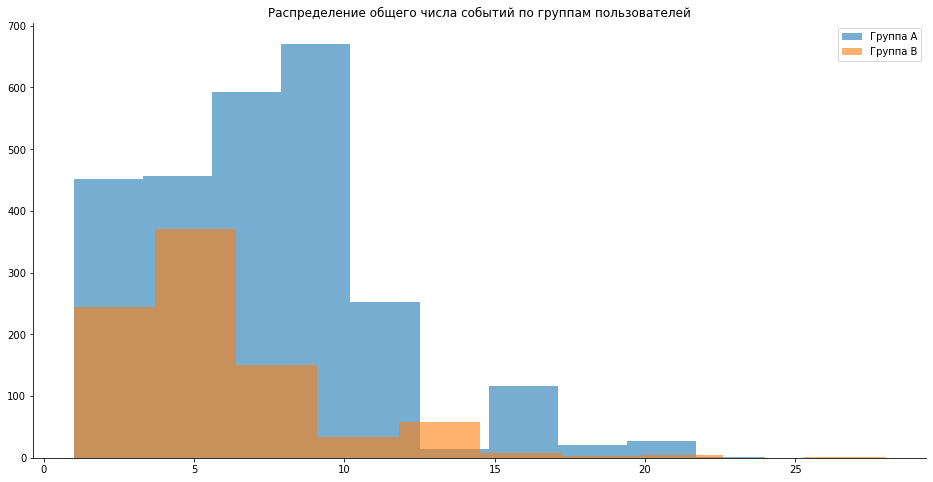

In [57]:
events_per_user_a.hist(label='Группа А', alpha=0.6)
events_per_user_b.hist(label='Группа B', alpha=0.6)
plt.title('Распределение общего числа событий по группам пользователей')
plt.legend()
plt.grid(False)
sns.despine()
plt.show()

In [58]:
fig = go.Figure()
fig.add_trace(go.Box(y=events_per_user_a, name='Группа А'))
fig.add_trace(go.Box(y=events_per_user_b, name='Группа В'))
fig.update_layout(title='Диаграмма размаха числа событий на пользователя между группами А и В', template='none')
fig.update_yaxes(title='Количество событий пользователя')
fig.show()

**Вывод:** распределения числа событий на пользователя различаются, и для контрольной *группы A*, оно смещено вправо, то есть пользователи совершали больше событий до внедрения новой системы рекомендации.

*Группа А:* среднее 7 событий, медиана - 6, минимум - 1, максимум - 24.

*Группа B:* среднее 5.8 событий, медиана - 6, минимум - 1, максимум - 28.

Медиана в обеих группах одинакова, однако в обеих группах есть выбросы, которые могут исказить результаты тестирования.

### 3.3 Проверка на предмет принадлежности пользователей к обеим группам одновременно или к конкурирующим тестам<a name="subparagraph3_3"></a>

In [59]:
print('Количество пользователей, попавших в обе группы теста рекомендательной системы:', len(set(data_a['user_id'].unique()).intersection(set(data_b['user_id'].unique()))))

Количество пользователей, попавших в обе группы теста рекомендательной системы: 0


**Вывод:** в отфильтрованных данных, пользователи не пересекаются по группам.

Также проверим, пересекаются ли пользователи из нашего теста рекомендательной системы с конкурирующими тестами, что может влиять на их поведение.

In [60]:
users_in_both_tests = set(final_ab_participants.query('ab_test == "recommender_system_test"')['user_id'].unique()) \
                .intersection(set(final_ab_participants.query('ab_test == "interface_eu_test"')['user_id'].unique()))

In [61]:
print('Количество пользователей, попавших в различные тесты одновременно:', len(users_in_both_tests))

Количество пользователей, попавших в различные тесты одновременно: 1602


Рассмотрим только пользователей из экспериментальных *групп В* обоих тестов, поскольку именно на них были испытаны изменения, а для контрольных *групп А* ничего не менялось:

In [62]:
users_b_in_both_tests = set(final_ab_participants.query('ab_test == "recommender_system_test" & group == "B"')['user_id'].unique()) \
                .intersection(set(final_ab_participants.query('ab_test == "interface_eu_test" & group == "B"')['user_id'].unique()))

In [63]:
print('Количество пользователей экспериментальной группы B, попавших в различные тесты:', len(users_b_in_both_tests))

Количество пользователей экспериментальной группы B, попавших в различные тесты: 344


In [64]:
print('Доля экспериментальной группы B, которая могла быть скомпрометирована:', round((len(users_b_in_both_tests) / data_b['user_id'].nunique()) * 100, 2),'%')

Доля экспериментальной группы B, которая могла быть скомпрометирована: 39.22 %


**Вывод:** как мы выяснили, механизм разбиения пользователей некорректно разделяет пользователей на группы - 344 пользователя попали в экспериментальные группы разных тестов. Поскольку мы не знаем точные временные рамки другого теста, мы не можем утверждать, что он имеет влияние на нашу экспериментальную группу - конкурирующий тест интерфейса мог проходить значительно раньше, чем тест рекомендательной системы. При этом, сам факт того, что пользователи из различных экспериментальных групп могут пересекаться говорит о том, что система разбиения незамедлительно требует исправления технических ошибок. По причине серьезной нехватки данных в текущем тесте, было бы расточительно исключать настолько значительную группу пользователей (39.22% всей экспериментальной группы) - при этом следует иметь в виду это допущение, а также уточнить, насколько сильным могло быть влияние другого A/B-теста.

### 3.4 Распределение числа событий по дням<a name="subparagraph3_4"></a>

In [65]:
fig = px.histogram(data_ab, color='group', x='event_dt', title='Гистограмма количества событий по времени', template='none')
fig.update_yaxes(title='Количество событий')
fig.update_xaxes(title='Дата')
fig.show()

**Вывод:** c 7 по 13 декабря общее число событий существенно не изменялось, а 14 декабря произошел резкий рост, в основном, за счет *группы A*. Пик был достигнут 21 декабря (вероятно, всплеск спроса перед Рождеством), а затем число событий стало неуклонно снижаться. Так как *группа A* в три раза больше *группы B*, то логично, что и число событий в этой группе будет значительно выше. В *группе B* отдельно мы наблюдаем более хаотичные колебания, предположительно вследствие недостаточного объема выборки. Однако и в *группе A*, и  в *группе В* мы видим тренд на снижение числа событий примерно после 21 декабря. После 29 декабря количество событий резко падает почти до нуля - не исключена техническая неисправность.

### 3.5 Особенности данных<a name="subparagraph3_5"></a>

* Прежде всего, как мы отметили ранее, *в обеих группах присутствует определенное число выбросов*, искажающих данные о распределении. Их можно было исключить, однако тогда доступных наблюдений станет еще меньше, чем требуется. Соответственно, имеющиеся данные нельзя считать нормально распределенными.


* Далее, мы отметили, что *группы были набраны неравномерно* - контрольная *группа A* почти в три раза больше, чем *группа B*, на которой тестируются изменения. Таким, образом, пользователи были разделены на группы некорректно, а текущего объема выборок недостаточно для получения значимых результатов. Так, планировалось зарегистрировать улучшение метрик не менее, чем на 10%. Если руководствоваться [оптимальным объемом выборки для данной задачи](https://www.evanmiller.org/ab-testing/sample-size.html#!30;80;5;10;1), то нам потребуется минимум по 3692 пользователя в каждой группе для проведения корректного теста, а не 2604 и 877 пользователей, как представлено в наших выборках.


* В выборку попали пользователи из других регионов (не EU), но были отфильтрованы. Механизм разбиения пользователей работает с ошибками.


* Время проведения тестирования было выбрано неудачно - оно совпадает с рождественским/новогодним сезоном праздников, что влияет на результаты теста.


* Эксперимент планировалось завершить 4 января 2021, однако данные по событиям не поступали после 30 декабря - возможно, на новогодних праздниках система перестала регистрировать события из-за технического сбоя, а не только потому что на праздниках пользователи реже посещали сервис.


* *Группы A и B* также несколько различаются по структуре используемых устройств - расчеты приведены ниже.

In [66]:
groups_by_device = data_ab.groupby('user_id')['device'].unique().reset_index()['device'].value_counts().reset_index()
groups_by_device = groups_by_device.rename(columns={'index':'device', 'device':'n_users'})
groups_by_device_a = data_a.groupby('user_id')['device'].unique().reset_index()['device'].value_counts().reset_index()
groups_by_device_a = groups_by_device_a.rename(columns={'index':'device', 'device':'n_users'})
groups_by_device_b = data_b.groupby('user_id')['device'].unique().reset_index()['device'].value_counts().reset_index()
groups_by_device_b = groups_by_device_b.rename(columns={'index':'device', 'device':'n_users'})

In [67]:
fig = go.Figure(data=[go.Pie(labels=groups_by_device['device'], values=groups_by_device['n_users'], hole=0.6)])
fig.update_traces(textinfo='label+value+percent')
fig.update_layout(title_text='Распределение пользователей по устройствам', title_x=0.5, showlegend=False)
fig.show()

In [68]:
fig = go.Figure(data=[go.Pie(labels=groups_by_device_a['device'], values=groups_by_device_a['n_users'], hole=0.6)])
fig.update_traces(textinfo='label+value+percent')
fig.update_layout(title_text='Распределение пользователей по устройствам в группе А', title_x=0.5, showlegend=False)
fig.show()

In [69]:
fig = go.Figure(data=[go.Pie(labels=groups_by_device_b['device'], values=groups_by_device_b['n_users'], hole=0.6)])
fig.update_traces(textinfo='label+value+percent')
fig.update_layout(title_text='Распределение пользователей по устройствам в группе B', title_x=0.5, showlegend=False)
fig.show()

**Вывод:** *группы A и B* различаются до долям устройств - в *группе B* больше доля Android - 46.2% против 43.7% в *группе A*. В *группе B* также выше доля iPhone (21.2% против 20% в *группе A*), а также ниже доля Mac (8.44% против 9.79%) и PC (24.2% против 26.5%). Таким образом, можно подытожить, что в *группе B* относительно больше пользователей на мобильных устройствах, а в контрольной *группе A* - на стационарных. Это также может исказить результаты тестирования.

[Вернуться к оглавлению](#introduction)

## 4. Проверка статистических гипотез<a name="paragraph4"></a>

Напишем функцию `significance_test` на основе z-test для проверки различий между долями двух генеральных совокупностей.

In [70]:
def significance_test(a, group_1, group_2, stage, users_group_1, users_group_2):

# a = significance level; 
# group_1, group_2 (groups for comparison); 
# stage (stage of the funnel) = [0, 1, 2, 3];
# users_group_1, users_group_2 (number of unique users);
    
    alpha = a

    successes = np.array([group_1[stage], group_2[stage]])
    trials = np.array([users_group_1, users_group_2])

    p1 = successes[0]/trials[0]
    p2 = successes[1]/trials[1]
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    difference = p1 - p2 

    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
    distr = st.norm(0, 1)  

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
        return p_value
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")
        return p_value

Далее визуализируем воронки, проведем тесты по этапам и затем скорректируем полученные p-value на ошибку множественных сравнений с помощью поправки Бонферрони.

In [71]:
users_group_a = data_a.groupby('user_id')['user_id'].nunique().count()
users_group_b = data_b.groupby('user_id')['user_id'].nunique().count()
group_a = data_a.groupby('event_name')['user_id'].nunique().reset_index()
group_a['index'] = [1,3,2,4]
group_a = group_a.sort_values(by='index')
group_b = data_b.groupby('event_name')['user_id'].nunique().reset_index()
group_b['index'] = [1,3,2,4]
group_b = group_b.sort_values(by='index')

In [72]:
event_counts_unique_a = data_a.groupby('event_name')['user_id'].nunique().sort_values(ascending=False).reset_index()
event_counts_unique_a['index'] = [1,2,4,3]
funnel_a = event_counts_unique_a.sort_values(by='index').replace({'event_name':{'login':'Вход', 'product_page':'Страница с товаром',
                                            'product_cart':'Корзина','purchase':'Покупка'}})

event_counts_unique_b = data_b.groupby('event_name')['user_id'].nunique().sort_values(ascending=False).reset_index()
event_counts_unique_b['index'] = [1,2,4,3]
funnel_b = event_counts_unique_b.sort_values(by='index').replace({'event_name':{'login':'Вход', 'product_page':'Страница с товаром',
                                            'product_cart':'Корзина','purchase':'Покупка'}})

In [73]:
fig = go.Figure()
fig.add_trace(go.Funnel(
    name = 'Группа A',
    y = funnel_a['event_name'],
    x = funnel_a['user_id'],
    textinfo = "value+percent initial+percent previous"))
fig.add_trace(go.Funnel(
    name = 'Группа B',
    y = funnel_b['event_name'],
    x = funnel_b['user_id'],
    textinfo = "value+percent initial+percent previous"))
fig.update_layout(title='Воронка событий в группах А и В', title_x = 0.5)
fig.show()

Гипотезы сформулируем следующим образом:

    H0: нет различий между долями двух генеральных совокупностей
    H1: существуют различия между долями двух генеральных совокупностей

In [74]:
test_results = []
for i in range(1,4):
    print(f'Тест на различие пропорций между группами A и B на {i} этапе воронки')
    test_results.append(significance_test(0.05, group_a['user_id'], group_b['user_id'], i, users_group_a, users_group_b))
    print('')

Тест на различие пропорций между группами A и B на 1 этапе воронки
p-значение:  0.21469192029582396
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Тест на различие пропорций между группами A и B на 2 этапе воронки
p-значение:  6.942739359416805e-06
Отвергаем нулевую гипотезу: между долями есть значимая разница

Тест на различие пропорций между группами A и B на 3 этапе воронки
p-значение:  0.04652482738393027
Отвергаем нулевую гипотезу: между долями есть значимая разница



Введем корректирующую поправку Бонферрони

In [75]:
test_results

[0.21469192029582396, 6.942739359416805e-06, 0.04652482738393027]

In [76]:
multipletests(test_results, method='bonferroni')

(array([False,  True, False]),
 array([6.44075761e-01, 2.08282181e-05, 1.39574482e-01]),
 0.016952427508441503,
 0.016666666666666666)

**Вывод:** прежде всего, необходимо отметить, что значения конверсии на всех этапах в экспериментальной группе ниже, чем в контрольной. То есть не исключено, что внедряемые изменения рекомендательной системы каким-либо образом могли ухудшить пользовательский опыт, что и привело к снижению конверсии. После введения поправок на множественные сравнения, единственным значимым изменением можно считать этап корзины. На остальных этапах не удалось выявить значимых различий, однако мы наблюдаем снижение конверсии на всех этапах воронки, а выявить различия, возможно, не удалось по причине недостаточного объема выборок. Не исключено, что при корректно проведенном тесте и достаточном объеме данных, значимые различия смогут быть найдены, и гипотеза о снижении конверсии в экспериментальной группе подтвердится.

[Вернуться к оглавлению](#introduction)

## 5. Общий вывод<a name="paragraph5"></a>

В данном проекте мы проанализировали результаты A/B-тестирования новой рекомендательной системы, развернутой для части пользователей из региона EU. Можем заключить, что тест был проведен с большим количеством нарушений, и его результаты не должны считаться валидными:

* В обеих группах присутствует определенное число выбросов, искажающих данные о распределении, кроме того, сами распределения далеки от нормальных.
* Группы были набраны неравномерно - контрольная *группа A* почти в три раза больше, чем *группа B*, и объема выборок недостаточно, чтобы зарегистрировать значимые изменения согласно поставленному тех.заданию.
* Время проведения тестирования было выбрано неудачно - оно совпадает с рождественским/новогодним сезоном праздников, что влияет на результаты теста.
* Эксперимент планировалось завершить 4 января 2021, однако данные по событиям не поступали после 30 декабря - не исключены технические ошибки логирования.
* Механизм разбиения пользователей на группы работает с ошибками - группы нельзя назвать разбитыми случайно: они не только кардинально различаются по размеру, но и различаются по составу устройств (больше стационарных устройств в контрольной группе и больше мобильных - в экспериментальной), а это вносит серьезные искажения в результаты.

При этом, отметим, что мы наблюдали снижение конверсии на всех шагах воронки в *группе B*, хотя единственным статистически значимым различием можно условно назвать лишь этап корзины. Этим результатам не следует доверять, но не исключено, что изменения в рекомендательной системе действительно могли негативно повлиять на пользовательский опыт - это предположение следует проверить с помощью организации нового теста, который учтет все замечания и исключит ошибки.

[Вернуться к оглавлению](#introduction)